In [402]:
# I will import the libraries at the very top for readability
# import required libraries
# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint
from collections import Counter
from sklearn.model_selection import GridSearchCV

# Decision Trees

## Methods

### Decision Tree

To start off, the decision tree is one of the supervised learning models and is able to work both for categorial data and continuous data. For categorical data, we can use Classification model and for continuous data, we can work with Regression model. In this tab, I will go through both classification and regression.

Decision trees are a great way to classify between two labels (can also be done with more than two). From a general point of view, the tree asks questions and splits data based on the answers. It will continue to ask questions until it perfectly splits the data into their respective labels, so we have to make sure not to overfit. This would lead to a split of the data and then the process would continue.

The decision tree is meant to boil things down as much as possible, to a point where all the data is split into their respective category. The problem with this method is that if allowed, it will overfit to the training data and perform poorly on the test data. To fix this, we can specify hyperparameters within the model such as maximum depth.

In the end, the best result will be one that maximizes the accuracy of both training and test data. If we are maximizing both, it means that the generalization the model is making works both in theory and practice. A next step for this model would be to use a random forest, rather than a decision tree, which creates many decision trees and creates a “vote” of the results to assign a label to your predicted data.

### GridSearchCV

In order to perform hyper parameter tuning, I used GridSearchCV package. GridSearchCV performs an exhaustive search over all combinations of hyperparameters. It uses cross-validation to evaluate the model's performance on different splits of the training data, helping to avoid overfitting and providing more reliable results for hyperparameter tuning.[^1]

[^1]: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 


## Classification
### Class Distribution

In order to perform Decision Tree Classification, I used the same features utilized for the Naive Bayes predictions. The cleaning process will be the same as the Naive Bayes tab.

In [381]:
wildlife = pd.read_csv('./data/wild_life_cleaned.csv')
df = wildlife[['IUCN','Species','Country','Value']]
new_li = []

for item in df.IUCN.tolist():
    if item == 'THREATENED':
        new_li.append('THREATENED')
    elif (item == 'TOT_KNOWN') or (item == 'THREAT_PERCENT'):
        new_li.append(np.nan)
    else:
        new_li.append('OTHER')
        
df.loc[:, 'IUCN'] = new_li
df = df.dropna().reset_index(drop = True)

df.IUCN = df.IUCN.astype('category')
df.Species = df.Species.astype('category')
df.Country = df.Country.astype('category')

from sklearn.preprocessing  import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

encoded_data = encoder.fit_transform(df[['Species']])

# convert the encoded data to a Pandas DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Species']))

# see if the result is threatened if we put Species, Country, Value
df2 = pd.concat([df[['IUCN','Value']],encoded_df], axis =1, ignore_index= True)
df2.columns = ['IUCN','Value'] + encoder.get_feature_names_out(['Species']).tolist()

# This part is for Class Distribution
c = df2.IUCN
C = Counter(c)
data_counter = C

data_dict = dict(data_counter)

df3 = pd.DataFrame(data_dict.items(), columns=['Category', 'Count'])

mapping = {'OTHER': 0, 'THREATENED': 1}
df3['Category'] = df3['Category'].map(mapping)

count_0 = df3[df3['Category'] == 0]['Count'].values[0]
count_1 = df3[df3['Category'] == 1]['Count'].values[0]
total = df3['Count'].sum()

ratio_0 = count_0 / total
ratio_1 =count_1 / total
print("Ratio of Category 0:", ratio_0)
print("Ratio of Category 1:", ratio_1)

Ratio of Category 0: 0.7314460596786534
Ratio of Category 1: 0.2685539403213466


The ratio of category 0, which is 'NOT THREATENED' Species, is 0.73 and the ratio of 'THREATENED' species is 0.26. We can already see that the target variable is already skewed, but let check if the decision tree model will work for our dataset. 

### Baseline Model

First, we will find the accuracy of a Decision Tree Classifier model. In order to perform this, we need to go through one more data cleaning process which is converting the string variables: 'THREATENED' to 1, and 'OTHER' to 0. Then we will split the data and train the model. 

In [382]:
# data cleaning
mapping = {'OTHER': 0, 'THREATENED': 1}
df2['IUCN'] = df2['IUCN'].map(mapping)
y = df2.IUCN
X = df2.drop(['IUCN'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create and train the model first attempt
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
model = clf.fit(X_train,y_train)

# making predictions with the model on the training and the testing data
pred = model.predict(X_test)
res = pd.DataFrame({'predicted': pred, 'actual': y_test}).reset_index(drop = True)

# calculate the accuracy
xx = 0
for i in range(res.shape[0]):
    if res.predicted[i] == res.actual[i]:
        xx += 1
    else: pass
print(f'The accuracy rate for Decision Tree Classifier is: {round(xx/res.shape[0],2)}') # divide to the size of test

The accuracy rate for Decision Tree Classifier is: 0.73


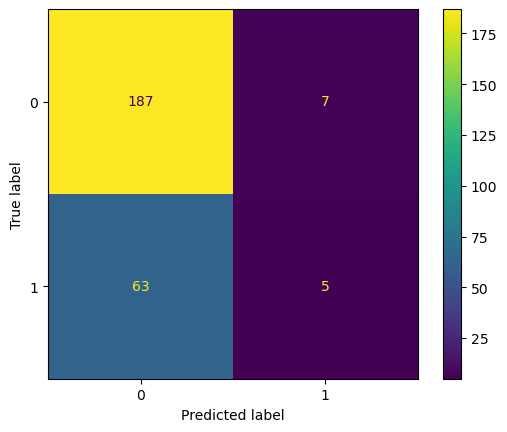

In [383]:
# generate a confusion matrix and metrics
cm = confusion_matrix(res.actual.tolist(), res.predicted.tolist(), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= model.classes_)
disp.plot()

When we set the test size to 20%, we can get a satisfied accuracy score which is around 69% to 75%. 

### Decision Tree

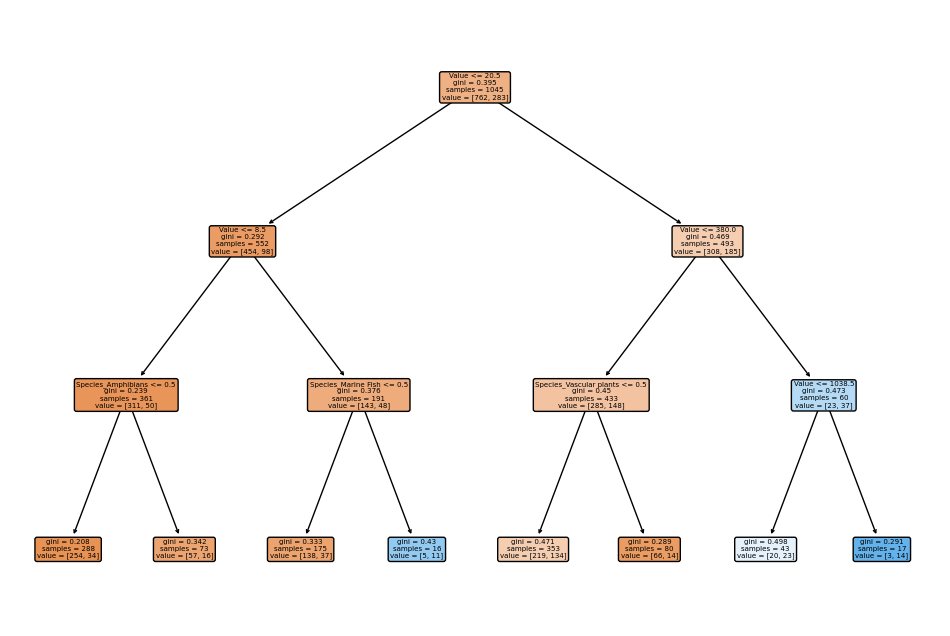

In [384]:
# plot the tree
plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, rounded=True, feature_names=X.columns.tolist())
plt.show()

#### Feature Selection

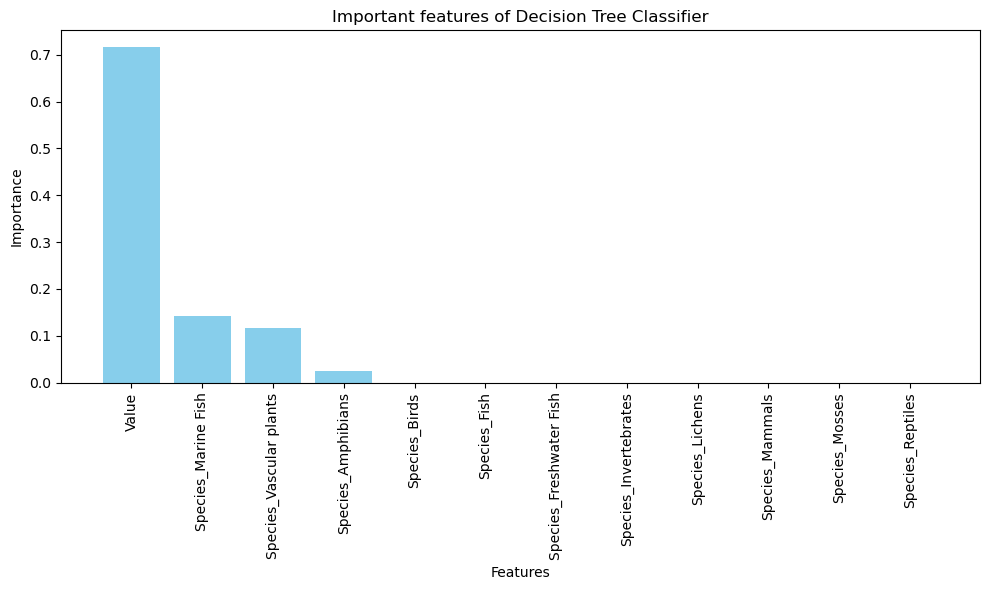

In [385]:
feature_importances = clf.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Important features of Decision Tree Classifier')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

After visualizing the decision tree, I tried to figure out which feature is the important one when splitting the tree. We can see that Value followed by vascular plants species, marine fish species and amphibians species were the most important features when training the tree. 

### Random Forest

Based on the decision tree above, we will also perform a random forest.

In [386]:
# create and train the model first attempt
rf_clf = RandomForestClassifier(random_state=42, max_depth=3)
model = rf_clf.fit(X_train, y_train)

#### Feature Selection

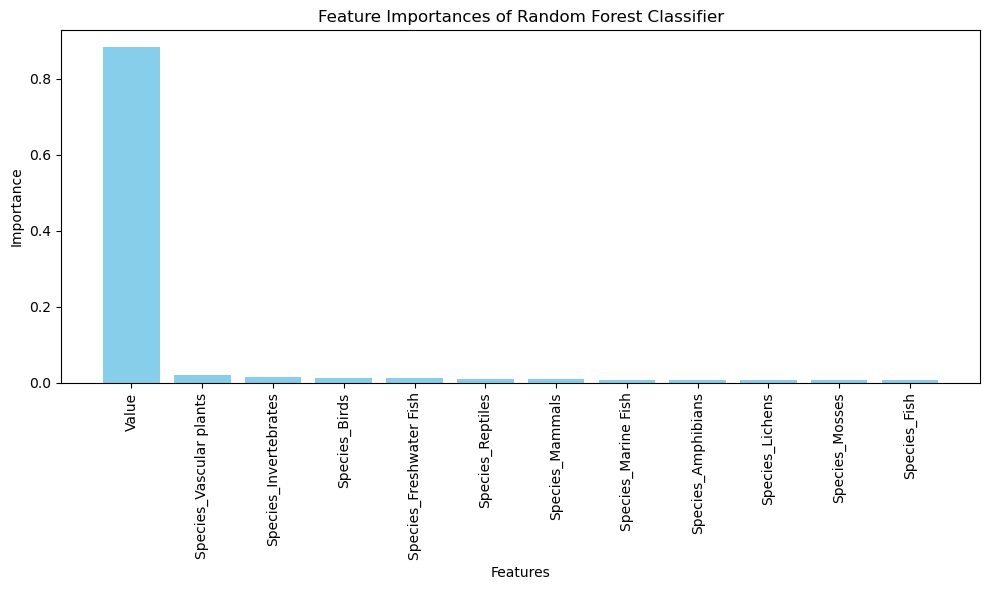

In [387]:
# get the important features
feature_importances = model.feature_importances_
feature_names = X_train.columns

# create a dataFrame and store features
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# plot the important features
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances of Random Forest Classifier')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Compared to one decision tree, we can clearly see that the Value is a significant feature when splitting the trees. 

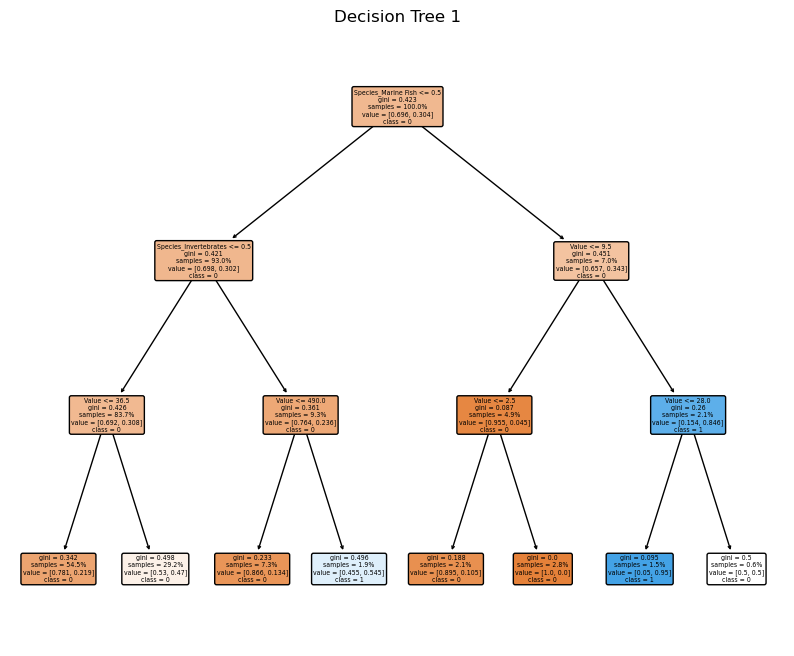

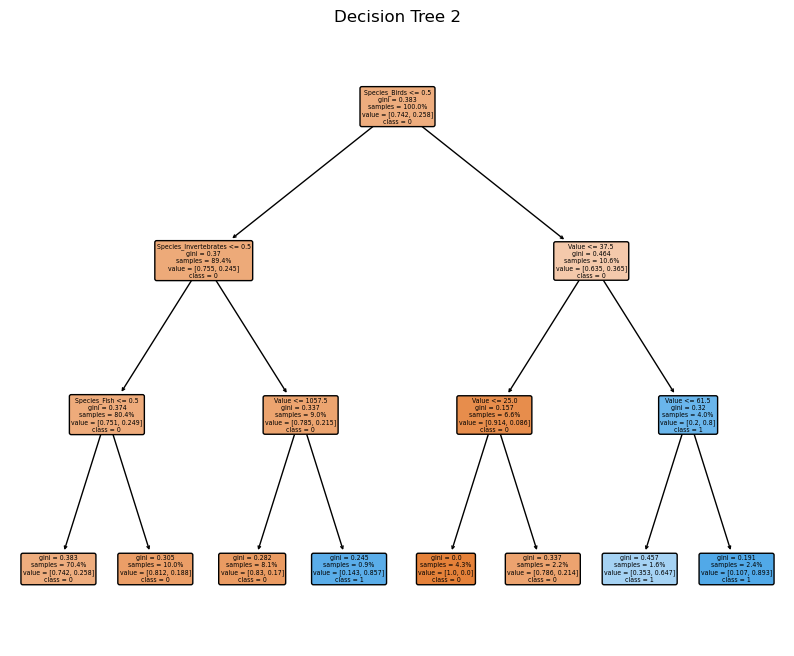

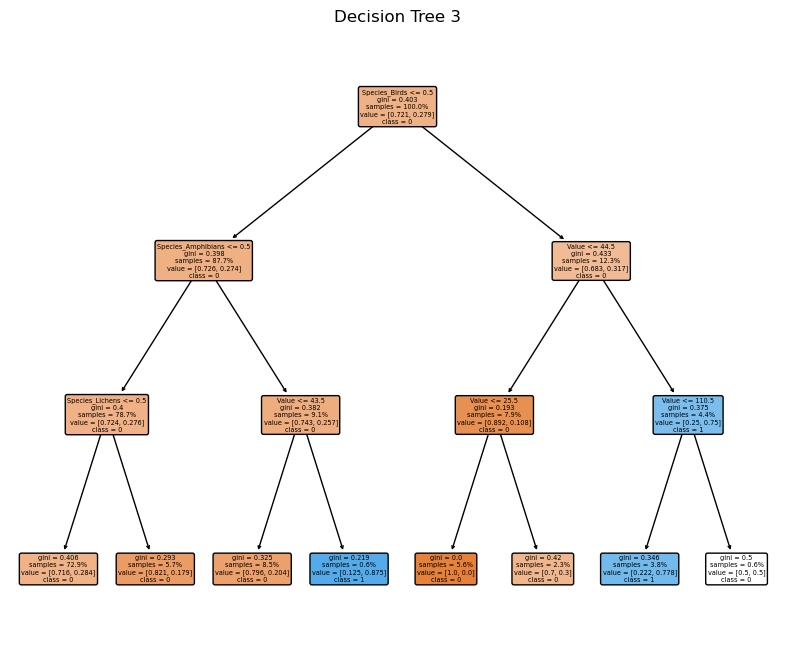

In [388]:
for i in range(3):
    tree = model.estimators_[i]

    # plot the tree
    plt.figure(figsize=(10, 8))
    plot_tree(tree, filled=True, feature_names=X_train.columns.tolist(), class_names=['0', '1'], rounded=True, proportion=True)
    plt.title(f'Decision Tree {i + 1}')
    plt.show()

### Model Tuning

In [389]:
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

best_estimator.fit(X_train, y_train)

yp_test = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, yp_test)
print("Best Parameters:", best_params)
print("Accuracy:", accuracy)


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy: 0.7442748091603053


In [390]:
# looping over hyperparameters and compare
test_results=[]
train_results=[]

for num_layer in range(1,20):
    model = DecisionTreeClassifier(max_depth=num_layer, random_state=42)
    model = model.fit(X_train, y_train)

    yp_train=model.predict(X_train)
    yp_test=model.predict(X_test)

    test_results.append([num_layer,accuracy_score(y_test, yp_test),recall_score(y_test, yp_test,pos_label=0),recall_score(y_test, yp_test,pos_label=1)])
    train_results.append([num_layer,accuracy_score(y_train, yp_train),recall_score(y_train, yp_train,pos_label=0),recall_score(y_train, yp_train,pos_label=1)])

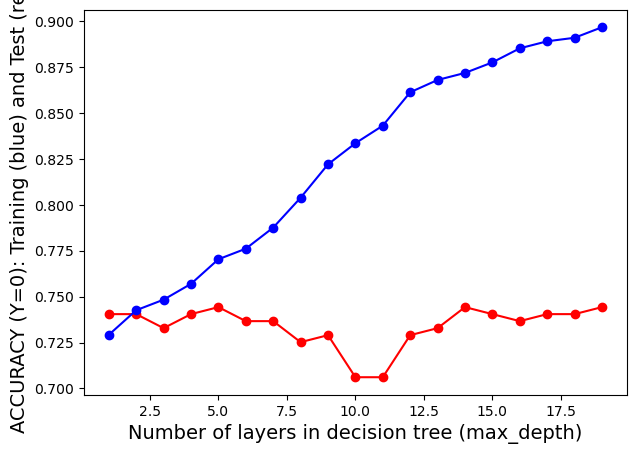

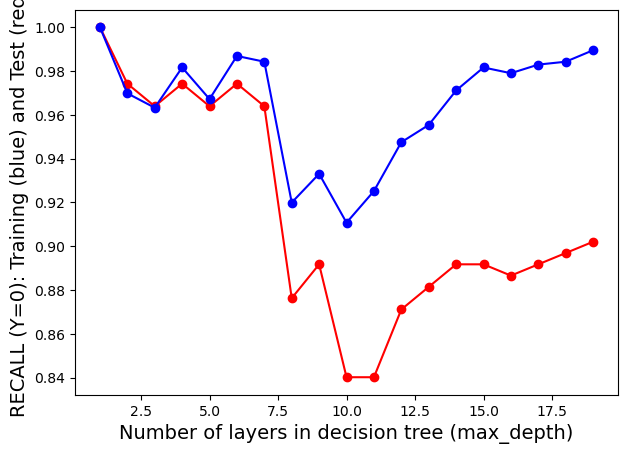

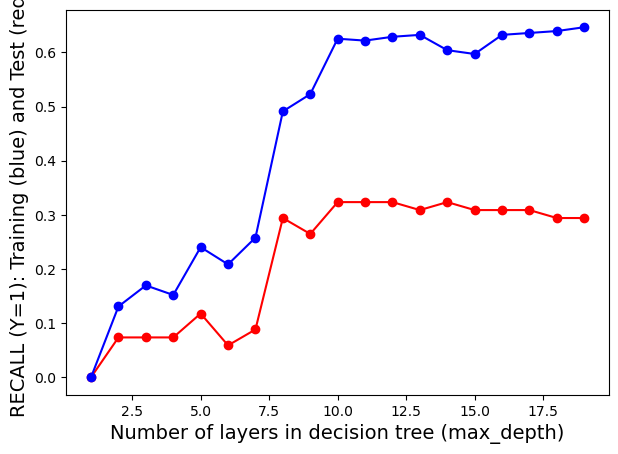

In [391]:
# generate plots to find best hyperparameters
test = pd.DataFrame(test_results, columns=['layers', 'accuracy', 'negativeRecall', 'positiveRecall'])
train = pd.DataFrame(train_results, columns=['layers', 'accuracy', 'negativeRecall', 'positiveRecall'])

plt.figure(figsize=(7,5))
plt.plot(test['layers'], test['accuracy'], 'r-o')
plt.plot(train['layers'], train['accuracy'], 'b-o')
plt.xlabel('Number of layers in decision tree (max_depth)', fontsize=14)
plt.ylabel('ACCURACY (Y=0): Training (blue) and Test (red)', fontsize=14)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(test['layers'], test['negativeRecall'], 'r-o')
plt.plot(train['layers'], train['negativeRecall'], 'b-o')
plt.xlabel('Number of layers in decision tree (max_depth)', fontsize=14)
plt.ylabel('RECALL (Y=0): Training (blue) and Test (red)', fontsize=14)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(test['layers'], test['positiveRecall'], 'r-o')
plt.plot(train['layers'], train['positiveRecall'], 'b-o')
plt.xlabel('Number of layers in decision tree (max_depth)', fontsize=14)
plt.ylabel('RECALL (Y=1): Training (blue) and Test (red)', fontsize=14)
plt.show()

### Final Results

Based on the plots above, we can see that the best parameters for the tress are as the following:

[* The results might differ]

- maximum depth of the tree should be around 7 to 8
- minimum number of leafs should be 4
- minimum number of samples required to split the internal nodes should be 2


In this particular case, we will be able to get the best accuracy score. I selected 8 for the max depth, and created a decision tree with the optimal parameters.

In [392]:
# retrying the model with the best parameters
best_model = DecisionTreeClassifier(max_depth=8, random_state=42, min_samples_leaf=4, min_samples_split=2)
best_model = best_model.fit(X_train,y_train)
# making predictions with the model on the training and the testing data
yp_train = best_model.predict(X_train)
yp_test = best_model.predict(X_test)

res = pd.DataFrame({'predicted': yp_test, 'actual': y_test}).reset_index(drop = True)

# calculate the accuracy
xx = 0
for i in range(res.shape[0]):
    if res.predicted[i] == res.actual[i]:
        xx += 1
    else: pass
print(f'The accuracy rate for Decision Tree Classifier is: {round(xx/res.shape[0],2)}') # divide to the size of test

The accuracy rate for Decision Tree Classifier is: 0.74


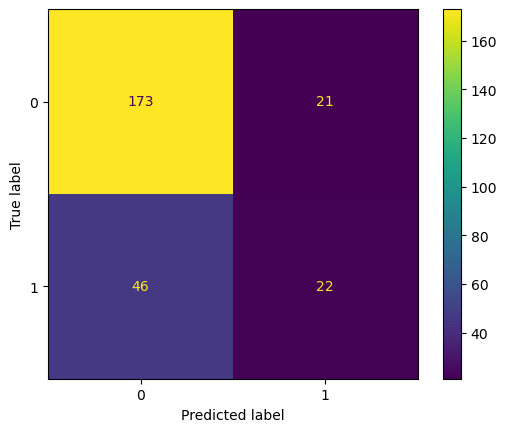

In [393]:
# generate a confusion matrix and metrics
cm = confusion_matrix(res.actual.tolist(), res.predicted.tolist(), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= model.classes_)
disp.plot()

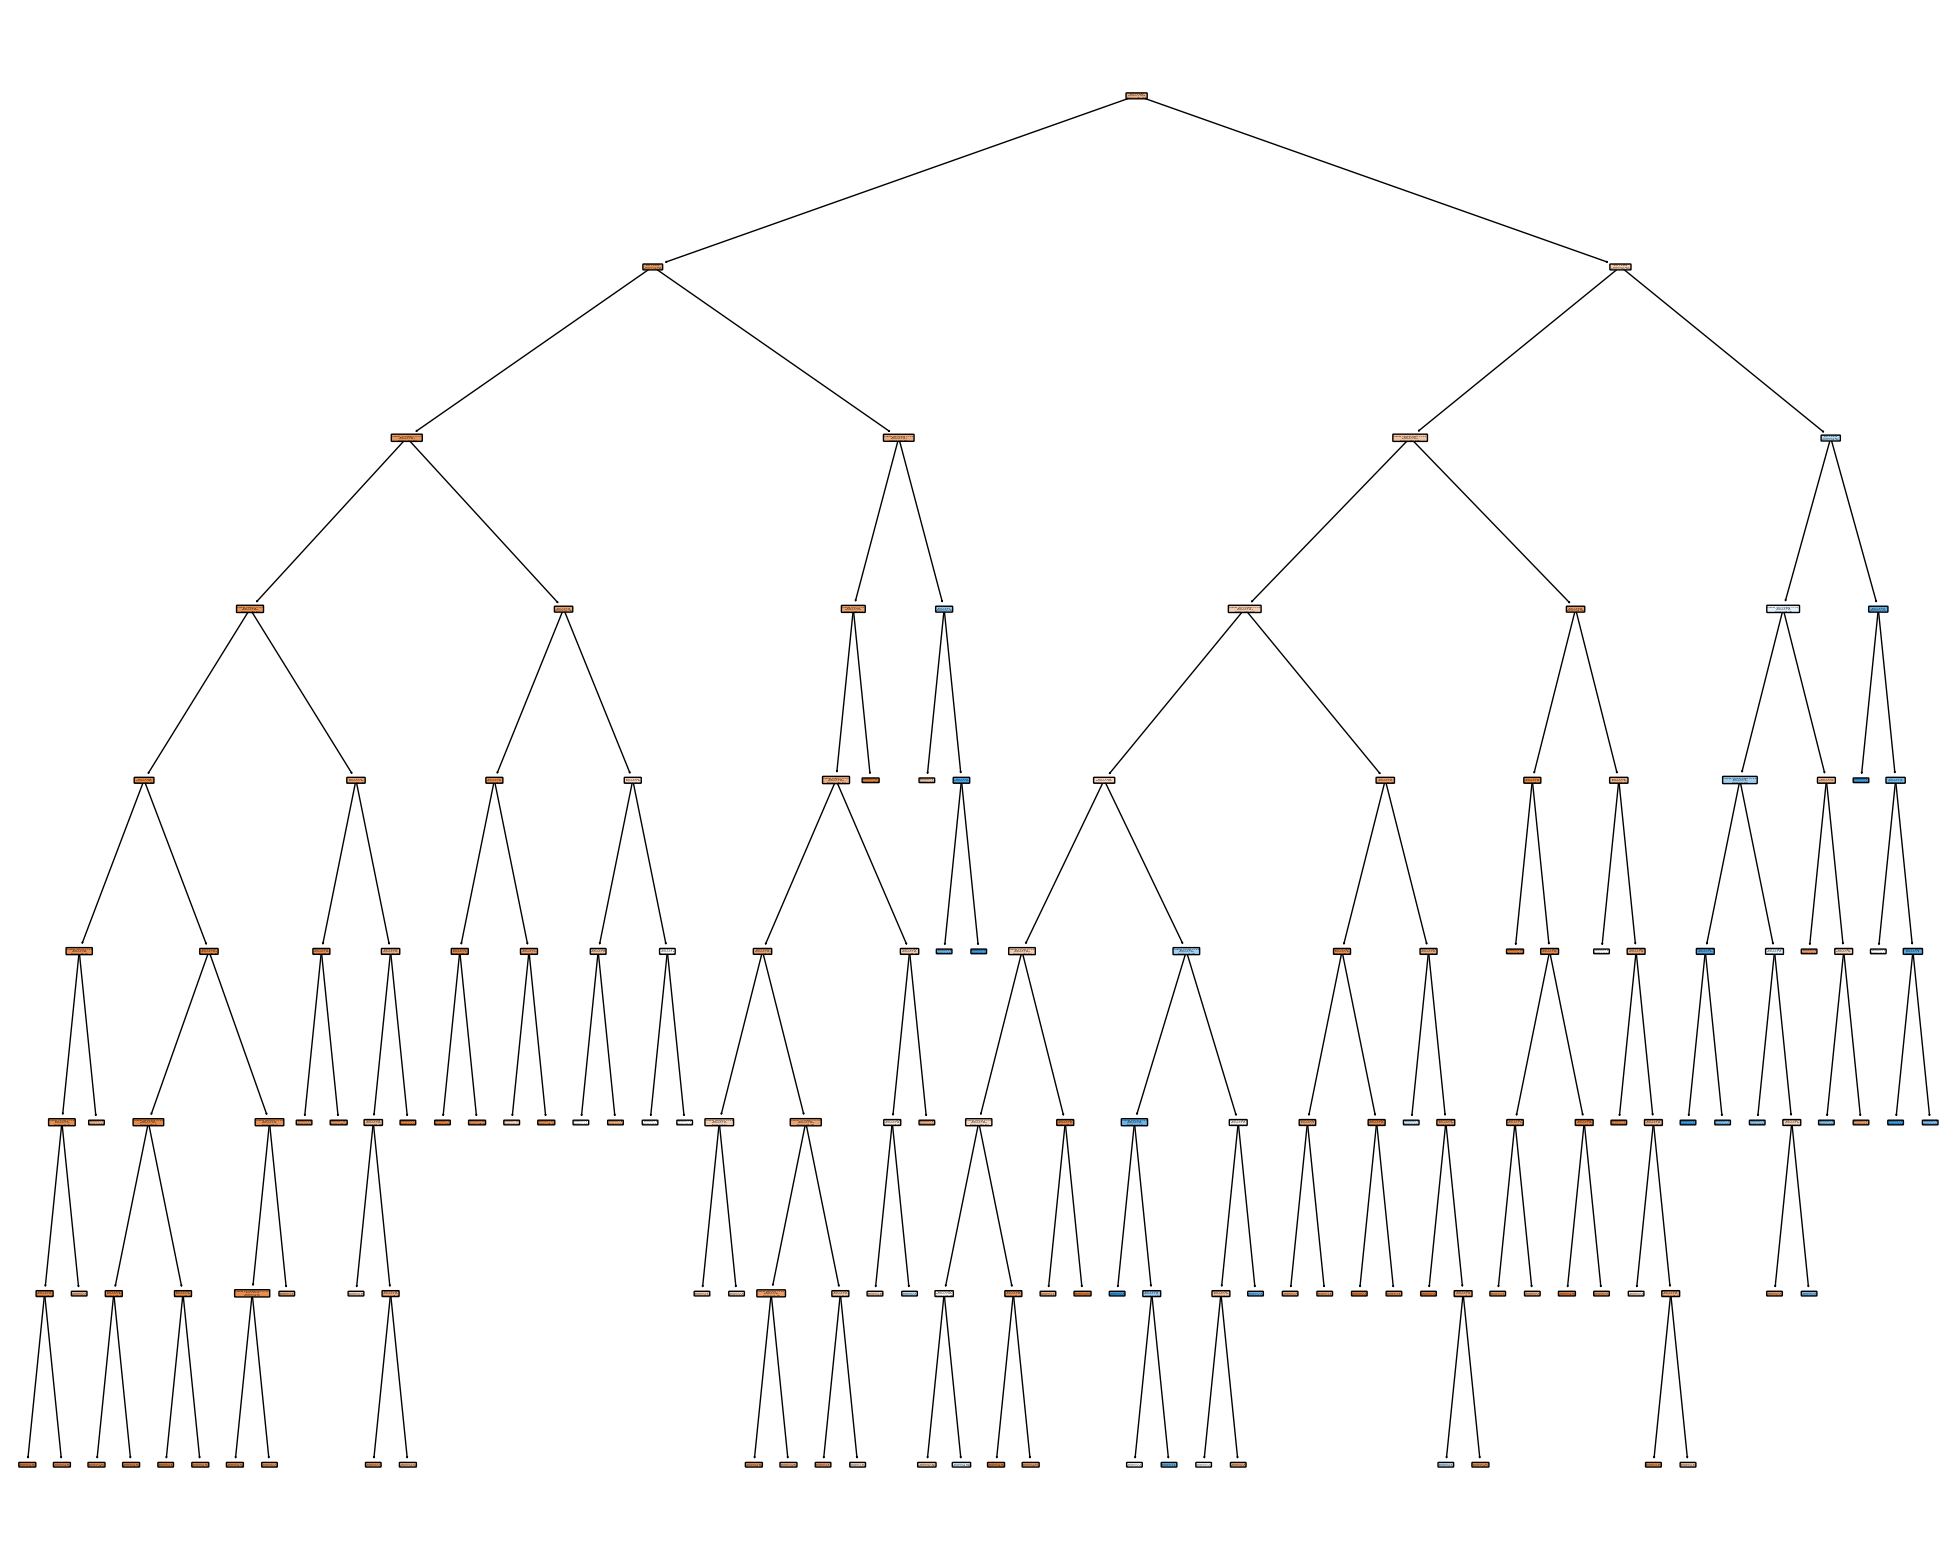

In [394]:
# plot the tree
plt.figure(figsize=(25, 20))
plot_tree(best_model, filled=True, rounded=True, feature_names=X.columns.tolist())
plt.show()

Compared to the very first decision tree we performed, the accuracy has increased as the parameter has been set to the optimal condition. 

### Conclusion

The optimal model did indeed yield better results than both the default decision tree and random forest classifier. The random classifier had an accuracy of approximately 0.73, while the default tree had an accuracy of approx. 0.71 and the optimal tree generated an accuracy of approx. 0.75. From a general perspective, this means that 75% of the guesses made by the model will be correct and the rest will be incorrect.

I think the accuracy itself was great, as I had prefered a model with an accuracy rate of approximately 75%. However, considering the gap between the accuracy scores of default decision tree, random forest and the optimal model, we cannot see a significant improvement among the models. I assume the reason of this would be an extremely skewed, overselected feature. Since the model depends significantly on the 'Value' feature, the model had a limited amount of data to train and depend on. On top of this, I had struggled with converting the categorical data to a numerical data, and I am certain that there will be a better way to clean the categorical data and based on how the data is cleaned, the model's accuracy score might differ as well. 

Although I was satisfied with the results: accuracy and hyper-parameter tuning, there would be a better way to improve the model. 

## Regression
### Class Distribution

For Decision Tree Regression part, we have to use continuous variables. In order to do so, feature selection and further data cleaning is necessary. The reason why we need further data cleaning even though we have already went over this process is because we are merging a whole new datset for a better performance in Decision Trees. By adding 'CO2 Emission' column which is a critical and relatable variable to predicting the threatened species value, we can improve the performance of the model.

In [395]:
# load and clean the data
wildlife = pd.read_csv('./data/wild_life_cleaned.csv')
climate = pd.read_csv('./data/climate_cleaned.csv')

climate_grouped = climate.groupby('Country')['Value'].mean()
climate = pd.DataFrame(climate_grouped)
climate['Value'] = climate['Value'].astype(int)

df2 = wildlife[['IUCN', 'Species', 'Country', 'Value']]
df_wide = df2.pivot(columns = 'IUCN', index = ['Species', 'Country'], values = 'Value').reset_index()
# check the null values
#print(df_wide.isna().sum())
# replace all the null values to 0
df_wide = df_wide.fillna(0)
#print(df_wide.isna().sum())

df2 = wildlife[['IUCN', 'Species', 'Country', 'Value']]
df_wide = df2.pivot(columns = 'IUCN', index = ['Species', 'Country'], values = 'Value').reset_index()
df_wide
final = pd.merge(df_wide, climate, on='Country')
final.rename(columns={'Value': 'Emissions'}, inplace=True)
final['Species'] = final['Species'].astype('category').cat.codes
final['Country'] = final['Country'].astype('category').cat.codes
#print(final.isna().sum())
final = final.fillna(0)
final = final.astype(int)
final.head()

,Species,Country,CRITICAL,ENDANGERED,THREATENED,THREAT_PERCENT,TOT_KNOWN,VULNERABLE,Emissions
0,0,0,17,8,39,16,239,14,146508
1,1,0,17,55,135,16,798,63,146508
2,2,0,8,20,53,0,5342,25,146508
3,3,0,4,17,38,12,315,17,146508
4,4,0,30,27,71,0,114940,14,146508


After merging the two datasets, further feature selection will be processed. I deliberately removed the 'THREAT_PERCENT' column becuase this can be too relatable to what we want to predict. If this column exists, the model will learn not from the other features but from this one column only. This might give us the highest accuracy since it will perform a one-on-one prediction, however this will be meaningless for our project goal. 


If the appropriate features are selected, we should divide the dataset into train and test dataset.

Below is the collected features training dataset.

In [396]:
# put the features excluding the target variable
X_cols = ['Species', 'Country', 'CRITICAL', 'ENDANGERED', 'TOT_KNOWN', 'VULNERABLE', 'Emissions']
X = final[X_cols] # dataframe
# put the target variable
y = final['THREATENED'] # Series
# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.head()

,Species,Country,CRITICAL,ENDANGERED,TOT_KNOWN,VULNERABLE,Emissions
193,0,20,0,2,27,3,158558
75,2,7,4,28,2012,74,3748
84,3,8,15,2,80,8,41416
363,3,37,2,3,0,3,162076
16,5,1,57,135,2100,251,20840


### Decision Tree

First, we will train the Decision Tree Regressor model and see how much accurate this model will be. 

Root Mean Squared Error (RMSE): 84.52778635849081


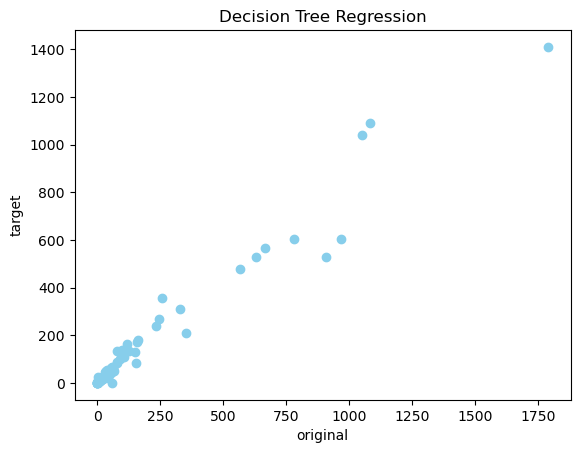

In [397]:
# create and train the model first attempt
regr = DecisionTreeRegressor(random_state=42)
model = regr.fit(X_train,y_train)
# making predictions with the model on the training and the testing data
yp_train = model.predict(X_train)
yp_test = model.predict(X_test)

# calculate the rmse and print it
rmse = np.sqrt(mean_squared_error(y_test, yp_test))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# scatter plot of y_test and y_pred_test
plt.figure()
plt.scatter(y_test, yp_test, color="skyblue", label="max_depth=2")
plt.xlabel("original")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.show()

### Random Forest

I will go over the same process as the Decision Tree Regressor for the Random Forest. The process will be similar. 

Root Mean Squared Error (RMSE): 56.29234663196529


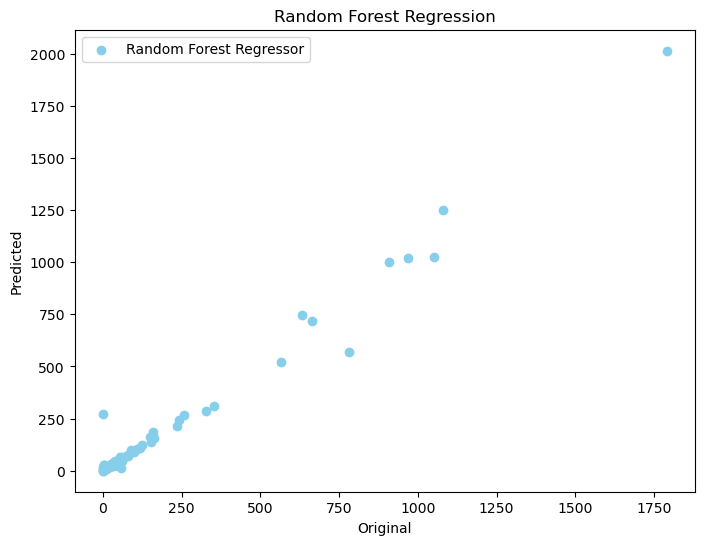

In [398]:
rf_regr = RandomForestRegressor(random_state=42)
rf_regr.fit(X_train, y_train)

yp_test = rf_regr.predict(X_test)

rmse = mean_squared_error(y_test, yp_test, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, yp_test, color="skyblue", label="Random Forest Regressor")
plt.xlabel("Original")
plt.ylabel("Predicted")
plt.title("Random Forest Regression")
plt.legend()
plt.show()

Using the RMSE metrics, I wanted to know how accurate this regression model will perform. The lower the RMSE, the closer the model will predict the true values. The wider the scatter of points or the higher the RMSE, the lower the accuracy of prediction will be. As we can see from the exact accuracy value, RMSE value, the scatter plot and the regressor tree plot, we can conclude that the accuracy is really low. 

Now, let's find out which feature has the most impact on predicting the target variable.

### Feature Selection

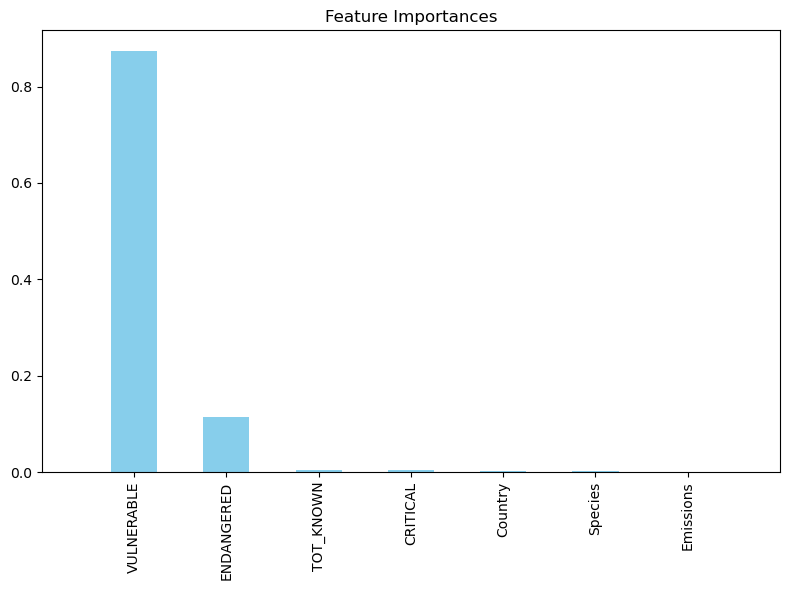

In [399]:
importances = model.feature_importances_

# get feature names
feature_names = X.columns 

# sort feature importances in desc order
indices = np.argsort(importances)[::-1]

# plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='skyblue', width=0.5)
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

Compared to the Decision Tree Classification, Decision Tree Regression evaluates the prediction accuracy based on the RMSE(Root Mean Squared Error). As we can see from above, the RMSE value of a default decision tree was approximately 84.52. However, the RMSE value of a random forest model was 56.29 which is way smaller than that of the decision tree model. This supports the fact that Random Forest model performs well than the decision tree models. That means, random forest model predicts the target variable better than the decision trees. 

It was also interesting to learn the difference between the classification model and regression model. Even though I dealt with the same data, the methods the two models use were totally different. I was pretty clear with the classification model, but I am not quite sure with the regression model and would like to learn and study more about this model. 

As we can see above, __'VULNERABLE'__ column was the most important feature when predicting the target variable.